<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_05/04_Expert_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Starting Expert Text Colab: Multi-input model with text + auxiliary metadata

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Load IMDB Reviews with unsupervised split to simulate real-world use
(train_data, test_data), ds_info = tfds.load(
    'imdb_reviews',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True
)

In [5]:
# Preprocess text: tokenize + encode
VOCAB_SIZE = 10000
MAX_LEN = 200

vectorizer = layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_LEN)
text_only = train_data.map(lambda text, label: text)
vectorizer.adapt(text_only)


In [6]:
# Preprocessing: Add auxiliary metadata (text length)
def preprocess(text, label):
    length = tf.strings.length(text)
    text_vec = vectorizer(text)
    meta = tf.cast(length, tf.float32) / 1000.0  # Normalize length
    return (text_vec, tf.reshape(meta, [1])), label

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_data.map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_data.map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [7]:
# Build expert model: text input + auxiliary input (text length)
def build_expert_text_model():
    text_input = layers.Input(shape=(MAX_LEN,), dtype=tf.int64, name="text_input")
    meta_input = layers.Input(shape=(1,), name="meta_input")

    x_text = layers.Embedding(VOCAB_SIZE, 128)(text_input)
    x_text = layers.Bidirectional(layers.LSTM(64))(x_text)
    x_text = layers.Dense(64, activation='relu')(x_text)

    x_meta = layers.Dense(16, activation='relu')(meta_input)

    x = layers.concatenate([x_text, x_meta])
    x = layers.Dense(32, activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=[text_input, meta_input], outputs=output)

model = build_expert_text_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [8]:
# Train
history = model.fit(train_ds, validation_data=test_ds, epochs=5)

# Evaluate
loss, acc = model.evaluate(test_ds)
print(f"✅ Final Test Accuracy: {acc:.4f}")



Epoch 1/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6438 - loss: 0.6170 - val_accuracy: 0.7331 - val_loss: 0.5442
Epoch 2/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.7167 - loss: 0.5627 - val_accuracy: 0.7851 - val_loss: 0.4768
Epoch 3/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.8109 - loss: 0.4317 - val_accuracy: 0.8448 - val_loss: 0.3803
Epoch 4/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8788 - loss: 0.2938 - val_accuracy: 0.8269 - val_loss: 0.4539
Epoch 5/5
665/665 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8888 - loss: 0.2778 - val_accuracy: 0.8573 - val_loss: 0.3492
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8560 - loss: 0.3596
✅ Final Test Accuracy: 0.8573


In [9]:
# After training and evaluation, now we enhance with predictions and visualization

import matplotlib.pyplot as plt

# Get predictions
y_true = []
y_pred = []

for (text_batch, meta_batch), labels in test_ds.take(20):  # Limit for speed
    preds = model.predict([text_batch, meta_batch])
    y_true.extend(labels.numpy())
    y_pred.extend((preds.flatten() > 0.5).astype(int))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


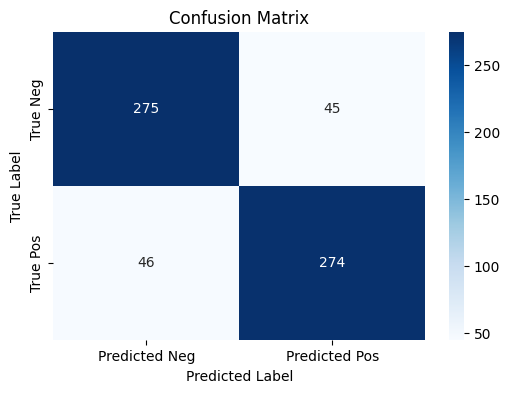

In [10]:
# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=["Negative", "Positive"])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Predicted Neg", "Predicted Pos"], yticklabels=["True Neg", "True Pos"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [11]:
# Print text classification report
print(report)

              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86       320
    Positive       0.86      0.86      0.86       320

    accuracy                           0.86       640
   macro avg       0.86      0.86      0.86       640
weighted avg       0.86      0.86      0.86       640

